In [1]:
import sys
import pickle
sys.path.append('../..')
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from lstm import transf_chik_pred
from lstm import apply_dengue_chik
from preprocessing import get_nn_data
from lstm import build_model, transf_chik_pred, transf_model
from pgbm_model import  cross_dengue_chik_prediction
from sklearn.metrics import mean_squared_error as mse 
import matplotlib.dates as mdates
from plots_pgbm import predicted_vs_observed as p_o_pgbm
from plots_lstm import plot_loss
fmt = mdates.DateFormatter('%d-%b\n%Y')

In [2]:
CITY = 3304557
CITY_NAME = 'Rio de Janeiro'
STATE = 'RJ'
FILENAME_DATA = f'../../data/chik_{CITY}_cluster.csv'

In [3]:
df_chik = pd.read_csv(FILENAME_DATA, index_col = 'Unnamed: 0' )
df_chik.index = pd.to_datetime(df_chik.index)
df_chik

,casos_3304557,casos_est_3304557,casos_est_min_3304557,casos_est_max_3304557,p_rt1_3304557,p_inc100k_3304557,temp_min_3304557,temp_max_3304557,umid_min_3304557,pressao_min_3304557,...,casos_3303203,casos_est_3303203,casos_est_min_3303203,casos_est_max_3303203,p_rt1_3303203,p_inc100k_3303203,temp_min_3303203,temp_max_3303203,umid_min_3303203,pressao_min_3303203
2010-01-03,0,0.0,0,0,0.000000,0.000000,24.919604,30.475486,66.631786,0.993175,...,0,0.0,0,0,0.0,0.0,24.576307,29.725882,69.104197,0.993357
2010-01-10,0,0.0,0,0,0.000000,0.000000,25.529044,32.125244,64.584100,0.995633,...,0,0.0,0,0,0.0,0.0,25.422472,32.090062,62.984778,0.995616
2010-01-17,0,0.0,0,0,0.000000,0.000000,25.359598,31.999538,61.707908,0.997928,...,0,0.0,0,0,0.0,0.0,25.379813,31.698752,60.738886,0.998017
2010-01-24,0,0.0,0,0,0.000000,0.000000,25.297887,32.134447,60.643620,0.996875,...,0,0.0,0,0,0.0,0.0,25.125737,31.560263,60.907331,0.996876
2010-01-31,0,0.0,0,0,0.000000,0.000000,24.752454,31.623125,61.756186,0.997307,...,0,0.0,0,0,0.0,0.0,24.321585,31.186035,61.491648,0.997287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-19,30,32.0,30,37,0.597792,0.474228,22.422786,29.246966,64.543411,1.001222,...,0,0.0,0,0,0.5,0.0,22.476702,28.662031,66.835809,1.001193
2023-03-26,19,23.0,20,28,0.093422,0.340851,22.705122,31.532885,55.172254,1.000216,...,0,0.0,0,0,0.5,0.0,22.541068,30.294761,63.231120,1.000406
2023-04-02,17,24.0,19,31,0.200430,0.355671,23.266584,28.715598,65.543365,0.999732,...,0,0.0,0,0,0.5,0.0,23.014365,28.333513,66.737119,0.999870
2023-04-09,18,30.0,22,42,0.685605,0.444588,21.788199,26.828910,69.926135,1.000576,...,0,0.0,0,0,0.5,0.0,21.670680,26.087616,73.382634,1.000633


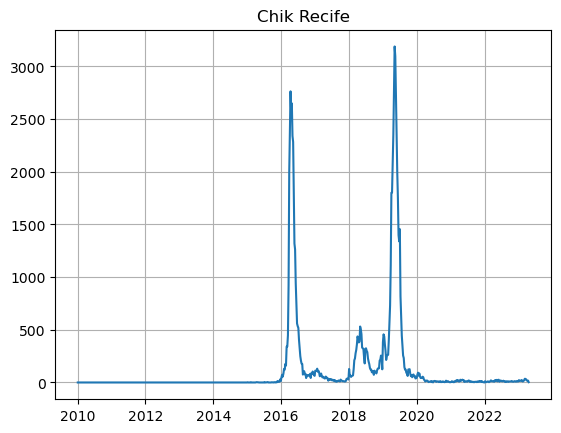

In [4]:
fig, ax = plt.subplots()

ax.plot(df_chik[f'casos_3304557'])

ax.set_title('Chik Recife')
plt.grid()
plt.show()

In [5]:
INI_DATE = '2015-11-01'
END_DATE_TRAIN = '2018-09-30'
END_DATE = '2022-01-02'

PREDICT_N = 4 # number of new days predicted
LOOK_BACK = 4 # number of last days used to make the prediction 
EPOCHS = 400
HIDDEN = 8
FEAT = 98 # number of features 

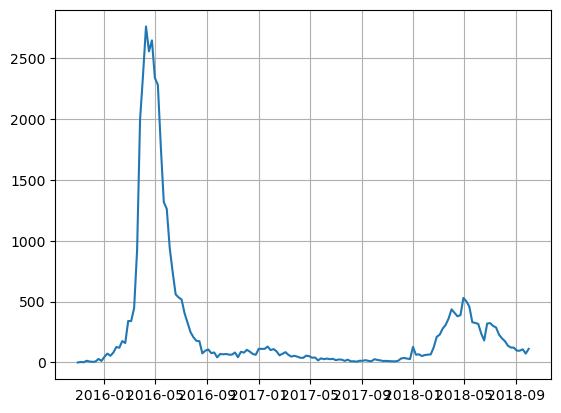

In [6]:
fig, ax = plt.subplots()

ax.plot(df_chik.loc[INI_DATE:END_DATE_TRAIN]['casos_3304557'])

ax.grid()

plt.show()

Apply the dengue model:

2023-05-07 00:35:22.150845: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


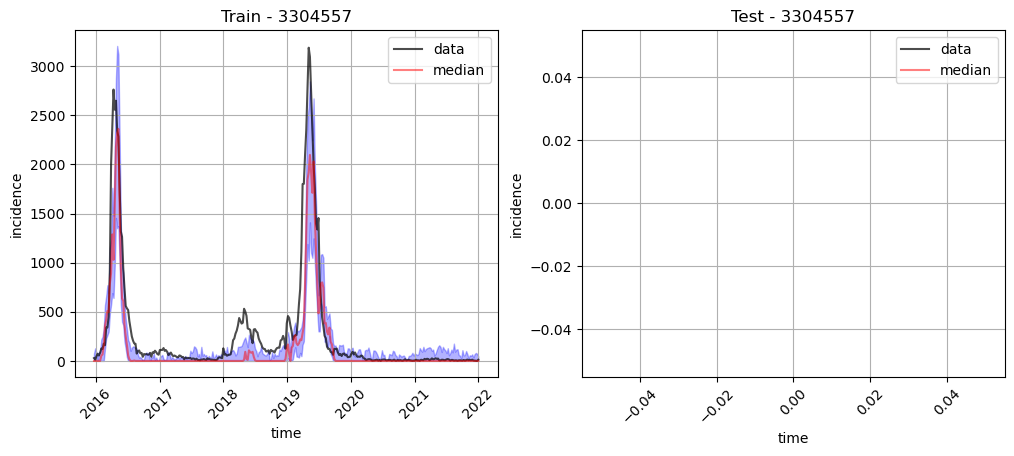

In [7]:
metrics = apply_dengue_chik(CITY, ini_date = INI_DATE, 
                         end_date = END_DATE, look_back = LOOK_BACK, batch_size = 1, 
                         predict_n = PREDICT_N,  label_m = f'msle_all', filename = FILENAME_DATA  )

Applying the **transfer learning** techinique:

- Using the model trained with `loss = 'msle'`:


Compilation Time :  0.0016810894012451172
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 98)]           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             6848      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 4)                 36        
                   

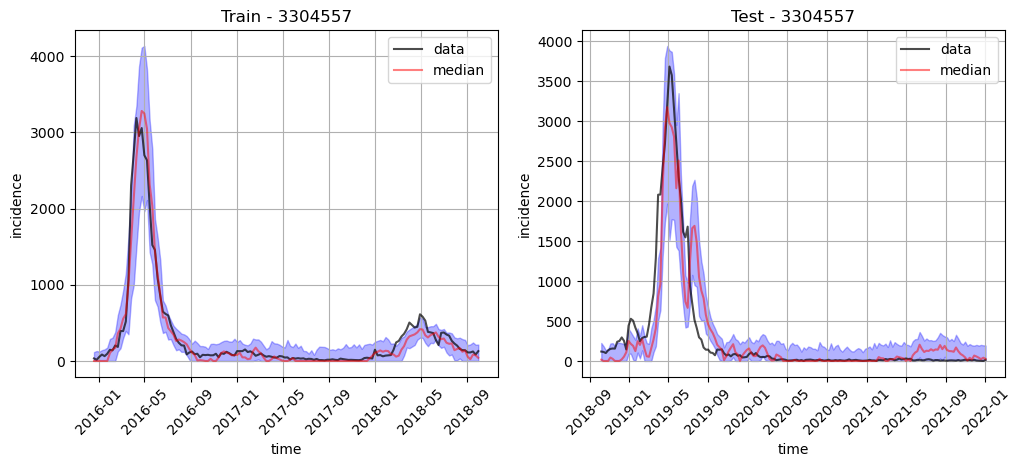

In [8]:

l1 = 1e-6
l2 = 1e-6
BATCH_SIZE = 1
EPOCHS = 100
filename = f'../../saved_models/lstm/trained_{CITY}_model_msle_all.h5'
model = transf_model(filename, l1,l2,HIDDEN, FEAT, PREDICT_N, LOOK_BACK, batch_size = BATCH_SIZE, lr = 0.001)
    
m_msle, hist, m_t, m_val = transf_chik_pred(model, CITY, ini_date = INI_DATE, end_train_date = END_DATE_TRAIN,  
                                end_date = END_DATE,  epochs= EPOCHS, 
                                predict_n = PREDICT_N, look_back = LOOK_BACK, validation_split = 0.1, monitor = 'val_loss', patience = 20, 
                                label = f'transf_msle', filename_data = FILENAME_DATA,  )

Apply the pgbm model:

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


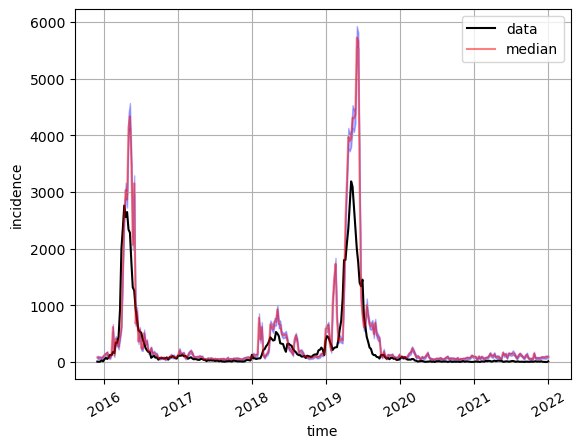

In [9]:
preds, preds25, preds975, X_data, targets = cross_dengue_chik_prediction(CITY, STATE, predict_n = PREDICT_N, look_back = LOOK_BACK, ini_date = INI_DATE, end_date = END_DATE, filename = FILENAME_DATA )
    